# On the Optimum Recognition Error and Reject Tradeoff

C.K. Chow 1970

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
from scipy.stats import norm, multinomial, uniform

plt.style.use('seaborn-whitegrid')
#plt.style.use('ggplot')

class Mixture(object):
    def __init__(self, generator_list, prior_list=None):
        self.generator_list = generator_list
        if prior_list is None:
            prior_list = np.ones(len(generator_list))/len(generator_list)
        self.prior_list = prior_list
        self.multinomial = multinomial(n=1, p=prior_list)
        self.n_components = len(generator_list)
        
    def rvs(self, size=1):
        samples = np.empty(size)
        components_idx = np.argmax(self.multinomial.rvs(size), axis=1)
        component_counts = np.unique(components_idx, return_counts=True)
        for c, count in zip(*component_counts):
            samples[components_idx == c] = self.generator_list[c].rvs(count)
        return samples
    
    def pdf(self, x):
        pdf = np.zeros(len(x))
        for c in range(self.n_components):
            pdf += self.prior_list[c]*self.generator_list[c].pdf(x)
        return pdf

First we will define the density distribution for both classes

$$F(x|i) = p(x|i)$$

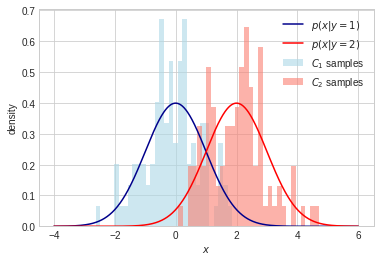

In [2]:
example_name = 'example_1'

if example_name == 'example_1':
    x = np.linspace(-4, 6, 700)
    mixture_c1 = Mixture([norm(loc=0, scale=1)],
                         prior_list=[1])
    mixture_c2 = Mixture([norm(loc=2, scale=1)],
                         prior_list=[1])
elif example_name == 'example_2':
    x = np.linspace(0, 2.5, 700)
    mixture_c1 = uniform(0, 1)
    mixture_c2 = uniform(0.5, 2)
elif example_name == 'example_3':
    mixture_c1 = Mixture([norm(loc=1, scale=1), 
                          norm(loc=10, scale=2)],
                         prior_list=[0.2, 0.8])
    mixture_c2 = Mixture([norm(loc=1, scale=2), 
                          norm(loc=10, scale=1)],
                         prior_list=[0.8, 0.2])
    
x_delta = x[1] - x[0]


samples = mixture_c1.rvs(100)
plt.hist(samples, bins=30, density=True, color='lightblue', label='$C_1$ samples', alpha=0.6)
plt.plot(x, mixture_c1.pdf(x), color='darkblue', label='$p(x|y=1)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

samples = mixture_c2.rvs(100)
plt.hist(samples, bins=30, density=True, color='salmon', label='$C_2$ samples', alpha=0.6)
plt.plot(x, mixture_c2.pdf(x), color='red', label='$p(x|y=2)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

The following is the corresponding posterior probability for class 1

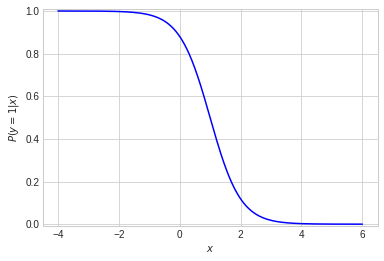

In [3]:
priors = np.array([.5, .5])

p_c1_g_x = priors[0]*mixture_c1.pdf(x)/(priors[0]*mixture_c1.pdf(x) + priors[1]*mixture_c2.pdf(x))
plt.plot(x, p_c1_g_x, color='blue')
plt.ylim(-0.01, 1.01)
plt.ylabel('$P(y=1|x)$')
plt.xlabel('$x$');

Optimum recognition rule is defined as

$$\delta(d_k|x) = 1 \quad (k\ne0)$$

accepting the pattern $x$ to belong to class $k$ given that

$$p_k(F(x|k) \ge p_iF(x|j) \quad \text{for all} \quad j=1, 2, ... n,$$

and

$$p_kF(x|k) \ge (1 - t) \sum_{i=1}^n p_iF(x|i)$$

or 

$$\delta(d_0|x) = 1$$

rejecting the pattern whenever

$$\max_i [p_iF(x|i)] < (1-t)\sum_{i=1}^n p_iF(x|i)$$

In [4]:
threshold = 0.25

Text(0.5, 0, 'x')

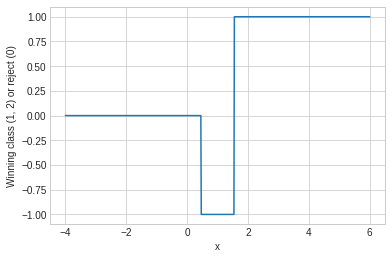

In [5]:
def optimum_recognition_rule(priors, p_x_g_k, threshold):
    '''
    priors array (n_classes,)
        prior probabilities per class, needs to sum to one
    p_g_g_k array of arrays (n_samples, n_classes)
        conditional probability density for each pattern given each class
    threshold float [0, 1]
        threshold to reject a sample from making a prediction
    '''
    p_x_and_k = priors*p_x_g_k
    argmax = np.argmax(p_x_and_k, axis=1)
    max_p_x_and_k = np.max(p_x_and_k, axis=1)
    reject = max_p_x_and_k < (1-threshold) * p_x_and_k.sum(axis=1)
    prediction = argmax
    prediction[reject] = -1
    return prediction
   
p_x_g_k = np.vstack([mixture_c1.pdf(x), mixture_c2.pdf(x)]).T
optimum_decision = optimum_recognition_rule(priors, p_x_g_k, threshold)
plt.plot(x, optimum_decision)
plt.ylabel('Winning class (1, 2) or reject (0)')
plt.xlabel('x')

## Probability of error

$$E(t) = \int_X \sum_{i=1}^n \sum_{i=1 \\ i \ne j} \delta(d_j|x) p_i F(x|i) dx$$

This corresponds to the probability of selecting the wrong class, on the accepted region.

Probability of error = 0.06133694411702005


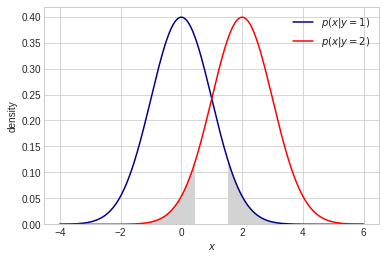

In [6]:
def probability_of_error(priors, p_x_g_k, x, threshold):
    n_classes = len(priors)
    optimum_decision = optimum_recognition_rule(priors, p_x_g_k, threshold)
    p_x_and_k = priors*p_x_g_k
    prediction = optimum_recognition_rule(priors, p_x_g_k, threshold)
    
    mask = 1 - np.eye(n_classes)[prediction].astype(bool)
    mask[prediction == -1] = False
    er = p_x_and_k*mask
    er = er.sum(axis=1)
    er = np.trapz(er, x=x)
    return er
    
er = probability_of_error(priors, p_x_g_k, x, threshold)
print("Probability of error =", er)

plt.plot(x, p_x_g_k[:,0], color='darkblue', label='$p(x|y=1)$')
plt.plot(x, p_x_g_k[:,1], color='red', label='$p(x|y=2)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

mask = optimum_decision != -1

# Functions with no gaps
#from matplotlib.patches import Polygon
#verts = [(x[mask][0], 0),
#         *zip(x[mask], p_x_g_k[mask].min(axis=1)),
#         (x[mask][-1], 0)]
#poly = Polygon(verts, facecolor='lightgrey', edgecolor='0.8')
#ax = plt.gca()
#ax.add_patch(poly)

# The following works even with gaps
plt.bar(x[mask], p_x_g_k[mask].min(axis=1), color='lightgrey', width=x_delta);

## Probability of reject

$$R(t) = \int_X \delta(d_0|x) \sum_{i=1}^n p_i F(x|i) dx$$

Probability of reject = 0.26272497583619236


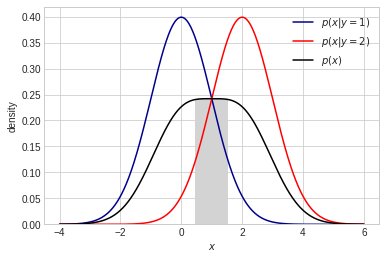

In [7]:
def probability_of_reject(priors, p_x_g_k, x, threshold):
    n_classes = len(priors)
    optimum_decision = optimum_recognition_rule(priors, p_x_g_k, threshold)
    p_x_and_k = priors*p_x_g_k
    prediction = optimum_recognition_rule(priors, p_x_g_k, threshold)
    
    pr = p_x_and_k
    pr[prediction != -1] = 0
    pr = pr.sum(axis=1)
    pr = np.trapz(pr, x=x)
    return pr

pr = probability_of_reject(priors, p_x_g_k, x, threshold)
print("Probability of reject =", pr)

full_mixture = Mixture([mixture_c1, mixture_c2])
p_x = full_mixture.pdf(x)
plt.plot(x, mixture_c1.pdf(x), color='darkblue', label='$p(x|y=1)$')
plt.plot(x, mixture_c2.pdf(x), color='red', label='$p(x|y=2)$')
plt.plot(x, p_x, color='black', label='$p(x)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

mask = optimum_decision == -1

#The following works even with empty spaces in between
plt.bar(x[mask], p_x[mask], color='lightgrey', width=x_delta);

# Probability of correct recognition

$$C(t) = \int_X \sum_{i=1}^n \delta(d_i|x) p_i F(x|i) dx = 1 - E(t) - R(t)$$

Probability of correct recognition = 0.6759063986879855
The following result should be the same = 0.6759380800467876


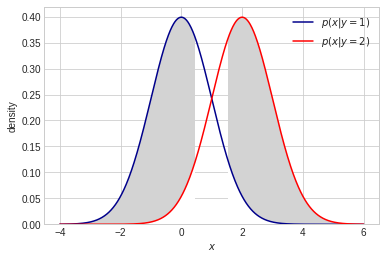

In [8]:
def probability_of_correct(priors, p_x_g_k, x, threshold):
    n_classes = len(priors)
    optimum_decision = optimum_recognition_rule(priors, p_x_g_k, threshold)
    p_x_and_k = priors*p_x_g_k
    prediction = optimum_recognition_rule(priors, p_x_g_k, threshold)
    
    mask = np.eye(n_classes)[prediction].astype(bool)
    pr = p_x_and_k*mask
    pr = pr.sum(axis=1)
    pr[prediction == -1] = 0
    pr = np.trapz(pr, x=x)
    return pr

def probability_of_correct_check(priors, p_x_g_k, x, threshold):
    E = probability_of_error(priors, p_x_g_k, x, threshold)
    R = probability_of_reject(priors, p_x_g_k, x, threshold)
    return 1 - E - R

pc = probability_of_correct(priors, p_x_g_k, x, threshold)
print("Probability of correct recognition =", pc)
print("The following result should be the same =", probability_of_correct_check(priors, p_x_g_k, x, threshold))

plt.plot(x, p_x_g_k[:,0], color='darkblue', label='$p(x|y=1)$')
plt.plot(x, p_x_g_k[:,1], color='red', label='$p(x|y=2)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

mask = optimum_decision != -1

# Functions with no gaps
#from matplotlib.patches import Polygon
#verts = [(x[mask][0], 0),
#         *zip(x[mask], p_x_g_k[mask].min(axis=1)),
#         (x[mask][-1], 0)]
#poly = Polygon(verts, facecolor='lightgrey', edgecolor='0.8')
#ax = plt.gca()
#ax.add_patch(poly)

# The following works even with gaps
plt.bar(x[mask], p_x_g_k[mask].max(axis=1), color='lightgrey', width=x_delta);
# TODO: Change superposing white bars for real interval
plt.bar(x[mask], p_x_g_k[mask].min(axis=1), color='white', width=x_delta);

# Probability of acceptance

$$A(t) = C(t) + E(t)$$

Probability of acceptance = 0.7372433428050056


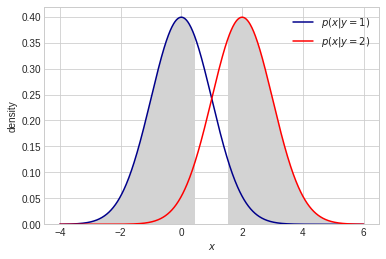

In [9]:
def probability_of_acceptance(priors, p_x_g_k, x, threshold):
    E = probability_of_error(priors, p_x_g_k, x, threshold)
    C = probability_of_correct(priors, p_x_g_k, x, threshold)
    return C + E

pa = probability_of_acceptance(priors, p_x_g_k, x, threshold)
print("Probability of acceptance =", pa)

plt.plot(x, p_x_g_k[:,0], color='darkblue', label='$p(x|y=1)$')
plt.plot(x, p_x_g_k[:,1], color='red', label='$p(x|y=2)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

mask = optimum_decision != -1

# The following works even with gaps
plt.bar(x[mask], p_x_g_k[mask].max(axis=1), color='lightgrey', width=x_delta);

# Restated optimum rule $\delta$

If we define the absolute probability density $F(x)$ as

$$F(x) = \sum_{i=1}^n p_i F(x|i)$$

and the random variable $m(x)$ (conditional probability of correctly recognising a pattern $x$) as

$$m(x) = \frac{\max_i p_i F(x|i)}{F(x)}$$

we can define a new optimum rule 

$$
\text{accept if} \quad m(x) \ge 1-t \\
\text{reject if} \quad m(x) < 1-t
$$

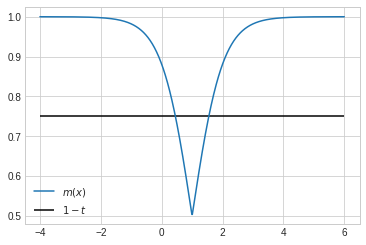

In [10]:
p_x_and_k = priors*p_x_g_k
m_x = np.max(p_x_and_k / p_x_and_k.sum(axis=1)[:, None], axis=1)
plt.plot(x, m_x, label='$m(x)$')
plt.hlines(1 - threshold, x.min(), x.max(), color='black', label=('$1 - t$'))
plt.legend()

# Acceptance and reject regions

We can divide the pattern space into two disjoint sets

Accepted region (or set)

$$ X_A(t) = \{x | m(x) \ge (1-t) \}$$

and the reject region (or set)

$$ X_R(t) = \{x | m(x) < (1-t) \}$$

Their corresponding probability is for the accepted region

$$ A(t) = \int_{X_A(t)} F(x) dx$$

and for the reject region

$$ R(t) = \int_{X_R(t)} F(x) dx$$


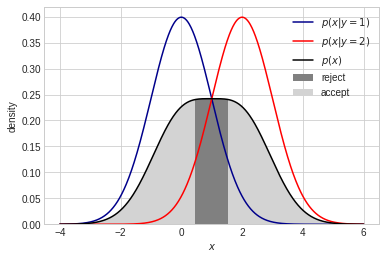

In [11]:
full_mixture = Mixture([mixture_c1, mixture_c2])
p_x = full_mixture.pdf(x)
plt.plot(x, p_x_g_k[:,0], color='darkblue', label='$p(x|y=1)$')
plt.plot(x, p_x_g_k[:,1], color='red', label='$p(x|y=2)$')
plt.plot(x, p_x, color='black', label='$p(x)$')
plt.ylabel('density')
plt.xlabel('$x$');

mask = optimum_decision == -1
#The following works even with empty spaces in between
plt.bar(x[mask], p_x[mask], color='grey', label='reject', width=x_delta);
mask = optimum_decision != -1
plt.bar(x[mask], p_x[mask], color='lightgrey', label='accept', width=x_delta);
plt.legend()

# Probability of correctness restated

$$
C(t) = \int_{X_A(t)} \max_i [p_i F(x|i)] dx \\
=  \int_{X_A(t)} m(x) F(x) dx
$$

In [12]:
def probability_of_correct_restated(priors, p_x_g_k, x, threshold):
    optimum_decision = optimum_recognition_rule(priors, p_x_g_k, threshold)

    p_x_and_k = priors*p_x_g_k
    m_x = np.max(p_x_and_k / p_x_and_k.sum(axis=1)[:, None], axis=1)
    density_of_correct = m_x * p_x_and_k.sum(axis=1)
    # Filter only the accepted region
    mask = optimum_decision != -1
    density_of_correct[optimum_decision == -1] = 0
    pc = np.trapz(density_of_correct, x=x)
    return pc

print('Probability of correctness')
print('The following results should be equal')
pc = probability_of_correct(priors, p_x_g_k, x, threshold)
print('Previous function = ', pc)
pc = probability_of_correct_restated(priors, p_x_g_k, x, threshold)
print('Restated function = ', pc)

Probability of correctness
The following results should be equal
Previous function =  0.6759063986879855
Restated function =  0.6759063986879855


In [13]:
def probability_of_error_restated(priors, p_x_g_k, x, threshold):
    optimum_decision = optimum_recognition_rule(priors, p_x_g_k, threshold)

    p_x_and_k = priors*p_x_g_k
    m_x = np.max(p_x_and_k / p_x_and_k.sum(axis=1)[:, None], axis=1)
    density_of_correct = (1 - m_x) * p_x_and_k.sum(axis=1)
    # Filter only the accepted region
    mask = optimum_decision != -1
    density_of_correct[optimum_decision == -1] = 0
    pc = np.trapz(density_of_correct, x=x)
    return pc

print('Probability of error')
print('The following results should be equal')
pc = probability_of_error(priors, p_x_g_k, x, threshold)
print('Previous function = ', pc)
pc = probability_of_error_restated(priors, p_x_g_k, x, threshold)
print('Restated function = ', pc)

Probability of error
The following results should be equal
Previous function =  0.06133694411702005
Restated function =  0.061336944117020065


# Error rate vs threshold

Text(0, 0.5, 'Error rate')

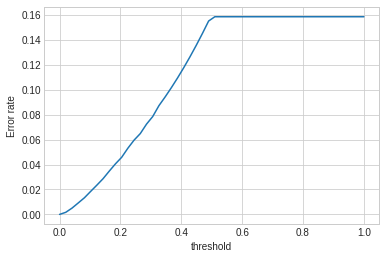

In [14]:
t_space = np.linspace(0, 1, 50)

er = [probability_of_error(priors, p_x_g_k, x, t) for t in t_space]

plt.plot(t_space, er)
plt.xlabel('threshold')
plt.ylabel('Error rate')

# Probability of reject vs threshold

Text(0, 0.5, 'Reject rate')

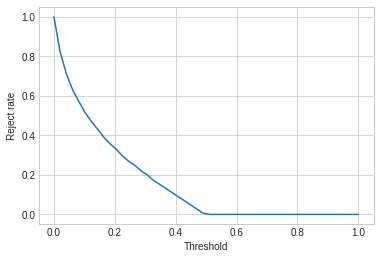

In [15]:
t_space = np.linspace(0, 1, 50)

pr = [probability_of_reject(priors, p_x_g_k, x, t) for t in t_space]

plt.plot(t_space, pr)
plt.xlabel('Threshold')
plt.ylabel('Reject rate')

# Error-reject tradeoff curve

Text(0, 0.5, 'Error rate')

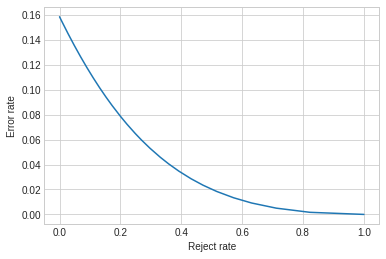

In [16]:
plt.plot(pr, er)
plt.xlabel('Reject rate')
plt.ylabel('Error rate')

# Accuracy-reject tradeoff curve

(0.0, 1.0)

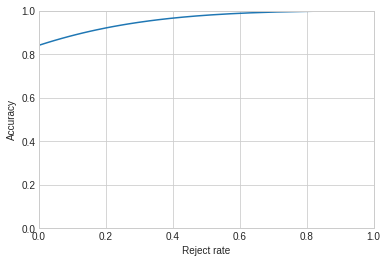

In [17]:
plt.plot(pr, 1 - np.array(er))
plt.xlabel('Reject rate')
plt.ylabel('Accuracy')
plt.xlim([0, 1])
plt.ylim([0, 1])

# TODO Check the following plot

The idea is to plot a figure that shows Accuracy with every given threshold considering the rejected instances as being correctly classified.

This means that there exist a lower bound in the diagonal which corresponds to the rejected samples being correct with an increasing threshold value.

The current approach uses the sum of the probability of correct and the probability of reject. However, this line resembles the previous  (1 - error rate) vs reject rate.

(0.0, 1.0)

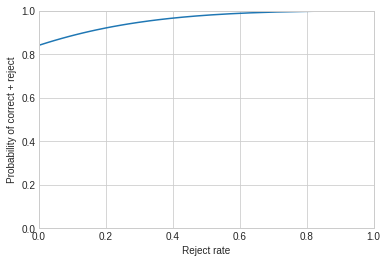

In [18]:
def probability_of_correct_and_reject(priors, p_x_g_k, x, threshold):
    C = probability_of_correct(priors, p_x_g_k, x, threshold)
    R = probability_of_reject(priors, p_x_g_k, x, threshold)
    return R + C

t_space = np.linspace(0, 1, 50)

pcr = [probability_of_correct_and_reject(priors, p_x_g_k, x, t) for t in t_space]
pr = [probability_of_reject(priors, p_x_g_k, x, t) for t in t_space]

plt.plot(pr, pcr)
plt.xlabel('Reject rate')
plt.ylabel('Probability of correct + reject')
plt.ylim([0, 1])
plt.xlim([0, 1])

# Two normal distributions with different separation (Fig. 5)

Text(0, 0.5, 'Error rate')

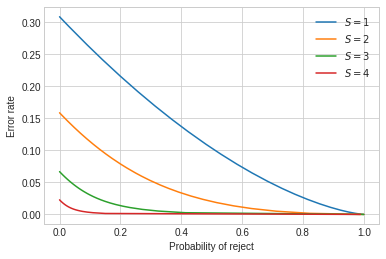

In [19]:
fig5_x = np.linspace(-4, 6, 700)
fig5_x_delta = fig5_x[1] - fig5_x[0]

for s in range(1, 5):
    fig5_priors = [.5, .5]

    fig5_c1 = Mixture([norm(loc=0, scale=1)],
                         prior_list=[1])
    fig5_c2 = Mixture([norm(loc=s, scale=1)],
                         prior_list=[1])
    #p_c1_g_x = fig5_priors[0]*fig5_c1.pdf(x)/(fig5_priors[0]*fig5_c1.pdf(x) + fig5_priors[1]*fig5_c2.pdf(x))
    fig5_p_x_g_k = np.vstack([fig5_c1.pdf(fig5_x), fig5_c2.pdf(fig5_x)]).T
    er = [probability_of_error(priors, fig5_p_x_g_k, fig5_x, t) for t in t_space]
    pr = [probability_of_reject(priors, fig5_p_x_g_k, fig5_x, t) for t in t_space]
    plt.plot(pr, er, label='$S={}$'.format(s))
plt.legend()
plt.xlabel('Probability of reject')
plt.ylabel('Error rate')

Text(0, 0.5, 'Error rate')

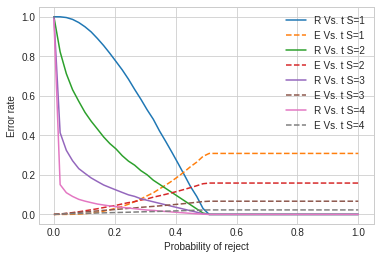

In [20]:
for s in range(1, 5):
    fig5_priors = [.5, .5]

    fig5_c1 = Mixture([norm(loc=0, scale=1)],
                         prior_list=[1])
    fig5_c2 = Mixture([norm(loc=s, scale=1)],
                         prior_list=[1])
    #p_c1_g_x = fig5_priors[0]*fig5_c1.pdf(x)/(fig5_priors[0]*fig5_c1.pdf(x) + fig5_priors[1]*fig5_c2.pdf(x))
    fig5_p_x_g_k = np.vstack([fig5_c1.pdf(fig5_x), fig5_c2.pdf(fig5_x)]).T
    er = [probability_of_error(priors, fig5_p_x_g_k, fig5_x, t) for t in t_space]
    pr = [probability_of_reject(priors, fig5_p_x_g_k, fig5_x, t) for t in t_space]

    plt.plot(t_space, pr, label='R Vs. t S={}'.format(s))
    plt.plot(t_space, er, '--', label='E Vs. t S={}'.format(s))

plt.legend()
plt.xlabel('Probability of reject')
plt.ylabel('Error rate')

# Two uniform distributions (Fig. 6 and 7)

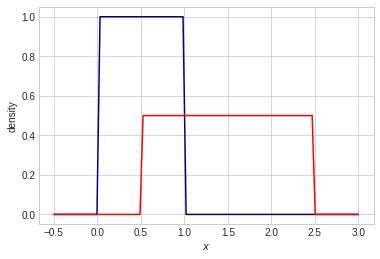

In [21]:
from scipy.stats import uniform

fig6_priors = [.5, .5]

fig6_x = np.linspace(-0.5, 3, 100)

fig6_c1 = uniform(0, 1)
fig6_c2 = uniform(0.5, 2)

plt.plot(fig6_x, fig6_c1.pdf(fig6_x), color='darkblue', label='$p(x|y=2)$')
plt.plot(fig6_x, fig6_c2.pdf(fig6_x), color='red', label='$p(x|y=2)$')
plt.ylabel('density')
plt.xlabel('$x$');

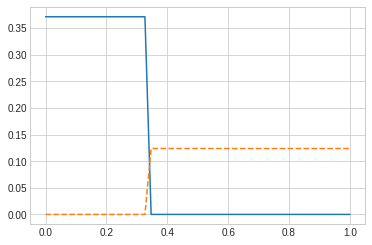

In [22]:
fig6_p_x_g_k = np.vstack([fig6_c1.pdf(fig6_x), fig6_c2.pdf(fig6_x)]).T
er = [probability_of_error(priors, fig6_p_x_g_k, fig6_x, t) for t in t_space]
pr = [probability_of_reject(priors, fig6_p_x_g_k, fig6_x, t) for t in t_space]

plt.plot(t_space, pr, label='R Vs. t S={}'.format(s))
plt.plot(t_space, er, '--', label='E Vs. t S={}'.format(s))